In [164]:
#import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
import json, time, urllib.parse
import requests
import time

In [2]:
#import the csv containing the list of articles
df = pd.read_csv('rare-disease_cleaned.AUG.2024.csv')
#take a glimpse into the dataset
df.head()

,disease,pageid,url
0,Klinefelter syndrome,19833554,https://en.wikipedia.org/wiki/Klinefelter_synd...
1,Aarskog–Scott syndrome,7966521,https://en.wikipedia.org/wiki/Aarskog–Scott_sy...
2,Abetalipoproteinemia,68451,https://en.wikipedia.org/wiki/Abetalipoprotein...
3,MT-TP,20945466,https://en.wikipedia.org/wiki/MT-TP
4,Ablepharon macrostomia syndrome,10776100,https://en.wikipedia.org/wiki/Ablepharon_macro...


In [4]:
#Putting the articles names in a list
articles = [f'{name}' for name in df['disease']]

In [5]:
#Sorting the articles alphabetically
articles.sort()

# API call from the document provided in Homework link - Data Extraction and Transformation
For the below chunk of code i am using the API function provided for the homework and extracting the views data for desktop, mobile-app and mobile web. Once extraction is done I will be saving the output as JSON files.

## For desktop views
Below code extracts data for desktop views of the articles

In [6]:
# The REST API 'pageviews' URL - this is the common URL/endpoint for all 'pageviews' API requests
API_REQUEST_PAGEVIEWS_ENDPOINT = 'https://wikimedia.org/api/rest_v1/metrics/pageviews/'

# This is a parameterized string that specifies what kind of pageviews request we are going to make
# In this case it will be a 'per-article' based request. The string is a format string so that we can
# replace each parameter with an appropriate value before making the request
API_REQUEST_PER_ARTICLE_PARAMS = 'per-article/{project}/{access}/{agent}/{article}/{granularity}/{start}/{end}'

# The Pageviews API asks that we not exceed 100 requests per second, we add a small delay to each request
API_LATENCY_ASSUMED = 0.010       # Assuming roughly 2ms latency on the API and network
API_THROTTLE_WAIT = (1.0/100.0)-API_LATENCY_ASSUMED

# When making a request to the Wikimedia API they ask that you include your email address which will allow them
# to contact you if something happens - such as - your code exceeding rate limits - or some other error 
REQUEST_HEADERS = {
    'User-Agent': '<anurag96@uw.edu>, University of Washington, MSDS DATA 512 - AUTUMN 2024',
}

# This is just a list of English Wikipedia article titles that we can use for example requests
ARTICLE_TITLES = articles

# This template is used to map parameter values into the API_REQUST_PER_ARTICLE_PARAMS portion of an API request. The dictionary has a
# field/key for each of the required parameters. In the example, below, we only vary the article name, so the majority of the fields
# can stay constant for each request. Of course, these values *could* be changed if necessary.
ARTICLE_PAGEVIEWS_PARAMS_TEMPLATE = {
    "project":     "en.wikipedia.org",
    "access":      "desktop",      # this should be changed for the different access types
    "agent":       "user",
    "article":     "",             # this value will be set/changed before each request
    "granularity": "monthly",
    "start":       "2015070100",   # start and end dates need to be set - 1st July 2015
    "end":         "2024100100"    # this is likely the wrong end date - 1st October 2024
}


In [7]:
#########
#
#    PROCEDURES/FUNCTIONS
#

def request_pageviews_per_article(article_title = None, 
                                  endpoint_url = API_REQUEST_PAGEVIEWS_ENDPOINT, 
                                  endpoint_params = API_REQUEST_PER_ARTICLE_PARAMS, 
                                  request_template = ARTICLE_PAGEVIEWS_PARAMS_TEMPLATE,
                                  headers = REQUEST_HEADERS):

    # article title can be as a parameter to the call or in the request_template
    if article_title:
        request_template['article'] = article_title

    if not request_template['article']:
        raise Exception("Must supply an article title to make a pageviews request.")

    # Titles are supposed to have spaces replaced with "_" and be URL encoded
    article_title_encoded = urllib.parse.quote(request_template['article'].replace(' ','_'))
    request_template['article'] = article_title_encoded
    
    # now, create a request URL by combining the endpoint_url with the parameters for the request
    request_url = endpoint_url+endpoint_params.format(**request_template)
    
    # make the request
    try:
        # we'll wait first, to make sure we don't exceed the limit in the situation where an exception
        # occurs during the request processing - throttling is always a good practice with a free
        # data source like Wikipedia - or other community sources
        if API_THROTTLE_WAIT > 0.0:
            time.sleep(API_THROTTLE_WAIT)
        response = requests.get(request_url, headers=headers)
        json_response = response.json()
    except Exception as e:
        print(e)
        json_response = None
    return json_response


In [8]:
desktop_views = {} #Create a blank dictionary to store desktop views

In [9]:
batch_size = 100  # Number of articles to process in each batch based on the API limit
for i in range(0, len(articles), batch_size):
    # Process articles in the current batch
    for article in articles[i:i+batch_size]:  # Loop through 100 articles at a time
        views = request_pageviews_per_article(article)
        
        # Check if 'items' exist in the response before proceeding
        if 'items' in views and views['items']:
            desktop_views[article] = views['items']
        else:
            print(f"No 'items' found for article: {article}")
    
    # Sleep for 1 second for API limit
    print(f"Processed {i+batch_size} articles, sleeping for 10 seconds...")
    time.sleep(1)

Processed 100 articles, sleeping for 10 seconds...
Processed 200 articles, sleeping for 10 seconds...
Processed 300 articles, sleeping for 10 seconds...
Processed 400 articles, sleeping for 10 seconds...
No 'items' found for article: Cystine/glutamate transporter
Processed 500 articles, sleeping for 10 seconds...
Processed 600 articles, sleeping for 10 seconds...
Processed 700 articles, sleeping for 10 seconds...
Processed 800 articles, sleeping for 10 seconds...
Processed 900 articles, sleeping for 10 seconds...
Processed 1000 articles, sleeping for 10 seconds...
Processed 1100 articles, sleeping for 10 seconds...
Processed 1200 articles, sleeping for 10 seconds...
Processed 1300 articles, sleeping for 10 seconds...
Processed 1400 articles, sleeping for 10 seconds...
Processed 1500 articles, sleeping for 10 seconds...
No 'items' found for article: Sulfadoxine/pyrimethamine
Processed 1600 articles, sleeping for 10 seconds...
No 'items' found for article: Trimethoprim/sulfamethoxazole
P

In [162]:
#saving the dictionary as the json
filename = 'rare-disease_monthly_desktop_2015070100-2024100100.json'

# Writing to a file
with open(filename, 'w') as f:
    json.dump(desktop_views, f, indent=4)

## For mobile app views
Below code extracts data for mobile application views of the articles

In [11]:
# The REST API 'pageviews' URL - this is the common URL/endpoint for all 'pageviews' API requests
API_REQUEST_PAGEVIEWS_ENDPOINT = 'https://wikimedia.org/api/rest_v1/metrics/pageviews/'

# This is a parameterized string that specifies what kind of pageviews request we are going to make
# In this case it will be a 'per-article' based request. The string is a format string so that we can
# replace each parameter with an appropriate value before making the request
API_REQUEST_PER_ARTICLE_PARAMS = 'per-article/{project}/{access}/{agent}/{article}/{granularity}/{start}/{end}'

# The Pageviews API asks that we not exceed 100 requests per second, we add a small delay to each request
API_LATENCY_ASSUMED = 0.002       # Assuming roughly 2ms latency on the API and network
API_THROTTLE_WAIT = (1.0/100.0)-API_LATENCY_ASSUMED

# When making a request to the Wikimedia API they ask that you include your email address which will allow them
# to contact you if something happens - such as - your code exceeding rate limits - or some other error 
REQUEST_HEADERS = {
    'User-Agent': '<anurag96@uw.edu>, University of Washington, MSDS DATA 512 - AUTUMN 2024',
}

# This is just a list of English Wikipedia article titles that we can use for example requests
ARTICLE_TITLES = articles

# This template is used to map parameter values into the API_REQUST_PER_ARTICLE_PARAMS portion of an API request. The dictionary has a
# field/key for each of the required parameters. In the example, below, we only vary the article name, so the majority of the fields
# can stay constant for each request. Of course, these values *could* be changed if necessary.
ARTICLE_PAGEVIEWS_PARAMS_TEMPLATE = {
    "project":     "en.wikipedia.org",
    "access":      "mobile-app",      # this should be changed for the different access types
    "agent":       "user",
    "article":     "",             # this value will be set/changed before each request
    "granularity": "monthly",
    "start":       "2015070100",   # start and end dates need to be set - 1st July 2015
    "end":         "2024100100"    # this is likely the wrong end date - 1st October 2024
}


In [12]:
#########
#
#    PROCEDURES/FUNCTIONS
#

def request_pageviews_per_article(article_title = None, 
                                  endpoint_url = API_REQUEST_PAGEVIEWS_ENDPOINT, 
                                  endpoint_params = API_REQUEST_PER_ARTICLE_PARAMS, 
                                  request_template = ARTICLE_PAGEVIEWS_PARAMS_TEMPLATE,
                                  headers = REQUEST_HEADERS):

    # article title can be as a parameter to the call or in the request_template
    if article_title:
        request_template['article'] = article_title

    if not request_template['article']:
        raise Exception("Must supply an article title to make a pageviews request.")

    # Titles are supposed to have spaces replaced with "_" and be URL encoded
    article_title_encoded = urllib.parse.quote(request_template['article'].replace(' ','_'))
    request_template['article'] = article_title_encoded
    
    # now, create a request URL by combining the endpoint_url with the parameters for the request
    request_url = endpoint_url+endpoint_params.format(**request_template)
    
    # make the request
    try:
        # we'll wait first, to make sure we don't exceed the limit in the situation where an exception
        # occurs during the request processing - throttling is always a good practice with a free
        # data source like Wikipedia - or other community sources
        if API_THROTTLE_WAIT > 0.0:
            time.sleep(API_THROTTLE_WAIT)
        response = requests.get(request_url, headers=headers)
        json_response = response.json()
    except Exception as e:
        print(e)
        json_response = None
    return json_response


In [13]:
mobile_app_views = {} #Create a blank dictionary to store the mobile views

In [15]:
batch_size = 100  # Number of articles to process in each batch as per API limit

for i in range(0, len(articles), batch_size):
    # Process articles in the current batch
    for article in articles[i:i+batch_size]:  # Loop through 100 articles at a time
        views = request_pageviews_per_article(article)
        
        # Check if 'items' exist in the response before proceeding
        if 'items' in views and views['items']:
            mobile_app_views[article] = views['items']
        else:
            print(f"No 'items' found for article: {article}")
    
    # Sleep for 1 second due to API limit
    print(f"Processed {i+batch_size} articles, sleeping for 5 seconds...")
    time.sleep(1)

Processed 100 articles, sleeping for 5 seconds...
Processed 200 articles, sleeping for 5 seconds...
Processed 300 articles, sleeping for 5 seconds...
Processed 400 articles, sleeping for 5 seconds...
No 'items' found for article: Cystine/glutamate transporter
Processed 500 articles, sleeping for 5 seconds...
Processed 600 articles, sleeping for 5 seconds...
Processed 700 articles, sleeping for 5 seconds...
Processed 800 articles, sleeping for 5 seconds...
Processed 900 articles, sleeping for 5 seconds...
Processed 1000 articles, sleeping for 5 seconds...
Processed 1100 articles, sleeping for 5 seconds...
Processed 1200 articles, sleeping for 5 seconds...
Processed 1300 articles, sleeping for 5 seconds...
Processed 1400 articles, sleeping for 5 seconds...
Processed 1500 articles, sleeping for 5 seconds...
No 'items' found for article: Sulfadoxine/pyrimethamine
Processed 1600 articles, sleeping for 5 seconds...
No 'items' found for article: Trimethoprim/sulfamethoxazole
Processed 1700 ar

## For mobile web views
Below code extracts data for mobile web views of the articles

In [16]:
# The REST API 'pageviews' URL - this is the common URL/endpoint for all 'pageviews' API requests
API_REQUEST_PAGEVIEWS_ENDPOINT = 'https://wikimedia.org/api/rest_v1/metrics/pageviews/'

# This is a parameterized string that specifies what kind of pageviews request we are going to make
# In this case it will be a 'per-article' based request. The string is a format string so that we can
# replace each parameter with an appropriate value before making the request
API_REQUEST_PER_ARTICLE_PARAMS = 'per-article/{project}/{access}/{agent}/{article}/{granularity}/{start}/{end}'

# The Pageviews API asks that we not exceed 100 requests per second, we add a small delay to each request
API_LATENCY_ASSUMED = 0.002       # Assuming roughly 2ms latency on the API and network
API_THROTTLE_WAIT = (1.0/100.0)-API_LATENCY_ASSUMED

# When making a request to the Wikimedia API they ask that you include your email address which will allow them
# to contact you if something happens - such as - your code exceeding rate limits - or some other error 
REQUEST_HEADERS = {
    'User-Agent': '<anurag96@uw.edu>, University of Washington, MSDS DATA 512 - AUTUMN 2024',
}

# This is just a list of English Wikipedia article titles that we can use for example requests
ARTICLE_TITLES = articles

# This template is used to map parameter values into the API_REQUST_PER_ARTICLE_PARAMS portion of an API request. The dictionary has a
# field/key for each of the required parameters. In the example, below, we only vary the article name, so the majority of the fields
# can stay constant for each request. Of course, these values *could* be changed if necessary.
ARTICLE_PAGEVIEWS_PARAMS_TEMPLATE = {
    "project":     "en.wikipedia.org",
    "access":      "mobile-web",      # this should be changed for the different access types
    "agent":       "user",
    "article":     "",             # this value will be set/changed before each request
    "granularity": "monthly",
    "start":       "2015070100",   # start and end dates need to be set - 1st July 2015
    "end":         "2024100100"    # this is likely the wrong end date - 1st October 2024
}


In [17]:
#########
#
#    PROCEDURES/FUNCTIONS
#

def request_pageviews_per_article(article_title = None, 
                                  endpoint_url = API_REQUEST_PAGEVIEWS_ENDPOINT, 
                                  endpoint_params = API_REQUEST_PER_ARTICLE_PARAMS, 
                                  request_template = ARTICLE_PAGEVIEWS_PARAMS_TEMPLATE,
                                  headers = REQUEST_HEADERS):

    # article title can be as a parameter to the call or in the request_template
    if article_title:
        request_template['article'] = article_title

    if not request_template['article']:
        raise Exception("Must supply an article title to make a pageviews request.")

    # Titles are supposed to have spaces replaced with "_" and be URL encoded
    article_title_encoded = urllib.parse.quote(request_template['article'].replace(' ','_'))
    request_template['article'] = article_title_encoded
    
    # now, create a request URL by combining the endpoint_url with the parameters for the request
    request_url = endpoint_url+endpoint_params.format(**request_template)
    
    # make the request
    try:
        # we'll wait first, to make sure we don't exceed the limit in the situation where an exception
        # occurs during the request processing - throttling is always a good practice with a free
        # data source like Wikipedia - or other community sources
        if API_THROTTLE_WAIT > 0.0:
            time.sleep(API_THROTTLE_WAIT)
        response = requests.get(request_url, headers=headers)
        json_response = response.json()
    except Exception as e:
        print(e)
        json_response = None
    return json_response


In [163]:
mobile_web_views = {} #Blank dictionary to store mobile web data viewed

In [19]:
batch_size = 100  # Number of articles to process in each batch

for i in range(0, len(articles), batch_size):
    # Process articles in the current batch (100 articles at a time)
    for article in articles[i:i+batch_size]:
        views = request_pageviews_per_article(article)
        
        # Check if 'items' exist in the response before proceeding
        if 'items' in views and views['items']:
            mobile_web_views[article] = views['items']
        else:
            print(f"No 'items' found for article: {article}")
    
    # Sleep for 1 seconddue to API limit
    print(f"Processed {i+batch_size} articles, sleeping for 5 seconds...")
    time.sleep(1)

Processed 100 articles, sleeping for 5 seconds...
Processed 200 articles, sleeping for 5 seconds...
Processed 300 articles, sleeping for 5 seconds...
Processed 400 articles, sleeping for 5 seconds...
No 'items' found for article: Cystine/glutamate transporter
Processed 500 articles, sleeping for 5 seconds...
Processed 600 articles, sleeping for 5 seconds...
Processed 700 articles, sleeping for 5 seconds...
Processed 800 articles, sleeping for 5 seconds...
Processed 900 articles, sleeping for 5 seconds...
Processed 1000 articles, sleeping for 5 seconds...
Processed 1100 articles, sleeping for 5 seconds...
Processed 1200 articles, sleeping for 5 seconds...
Processed 1300 articles, sleeping for 5 seconds...
Processed 1400 articles, sleeping for 5 seconds...
Processed 1500 articles, sleeping for 5 seconds...
No 'items' found for article: Sulfadoxine/pyrimethamine
Processed 1600 articles, sleeping for 5 seconds...
No 'items' found for article: Trimethoprim/sulfamethoxazole
Processed 1700 ar

In [20]:
import copy #uing copy module to create a copy of dictionary
mobile_views = copy.deepcopy(mobile_app_views) #taking a copy of mobile_app_views

In [21]:
for i in articles: #loop through all the articles
    if i in mobile_app_views: #if article is present in API output
        for j in range(len(mobile_app_views[i])):  
            if (mobile_app_views[i][j]['article'] == mobile_web_views[i][j]['article']) and (mobile_app_views[i][j]['timestamp'] == mobile_web_views[i][j]['timestamp']): #if artcile name and month match
                mobile_views[i][j]['views'] = mobile_app_views[i][j]['views'] + mobile_web_views[i][j]['views']#total mobile views is sum of the app and web versions



In [160]:
#saving the dictionary as the json

filename = 'rare-disease_monthly_mobile_2015070100-2024100100.json'

# Writing to a file
with open(filename, 'w') as f:
    json.dump(mobile_views, f, indent=4)

## For combined views i.e. mobile + desktop
Below code combines mobile and desktop views to get the total views

In [23]:
total_views = copy.deepcopy(mobile_views) #make a copy of mobile_views

In [24]:
for i in articles: #loop through all articles
    if i in mobile_views:
        for j in range(len(mobile_views[i])): 
            if (mobile_views[i][j]['article'] == desktop_views[i][j]['article']) and (mobile_views[i][j]['timestamp'] == desktop_views[i][j]['timestamp']): #check if article name and month match
                total_views[i][j]['views'] = mobile_views[i][j]['views'] + desktop_views[i][j]['views'] #add mobile and desktop views

In [25]:
for article, records in total_views.items():
    for record in records:
        record.pop('access', None) #remove the key access

In [161]:
#saving the dictionary as the json

filename = 'rare-disease_monthly_cumulative_2015070100-2024100100.json'

# Writing to a file
with open(filename, 'w') as f:
    json.dump(total_views, f, indent=4)

# Analysis 

## Max Avg and Min Avg
Get the maximum and minimum average for views. This is done by summing views and dividing by avaialble months of data

### Get desktop highest and lowest average
Do this for desktop views

In [41]:
desktop_articles_avg_views = {} #blank dictionary

In [42]:
for article in articles: #loop through all sorted articles
    total_views = 0
    if article in desktop_views:
        for month in range(len(desktop_views[article])): #for all months available
            total_views += desktop_views[article][month]['views'] #sum total views
        desktop_articles_avg_views[article] = total_views/len(desktop_views[article])  #divide by number of months to get average   

In [45]:
desktop_articles_max_avg = max(desktop_articles_avg_views, key=desktop_articles_avg_views.get) #get article with maximum avg
desktop_articles_min_avg = min(desktop_articles_avg_views, key=desktop_articles_avg_views.get) #get article with minimum avg

In [48]:
print(f'The article with the max avg views is {desktop_articles_max_avg} and that of min is {desktop_articles_min_avg}.')

The article with the max avg views is Black Death and that of min is Filippi Syndrome.


### Get mobile highest and lowest average
Do this for mobile views

In [51]:
mobile_articles_avg_views = {} #blank dictionary

In [52]:
for article in articles: #loop through all sorted articles
    total_views = 0
    if article in mobile_views:
        for month in range(len(mobile_views[article])): #for all months available
            total_views += mobile_views[article][month]['views'] #sum total views
        mobile_articles_avg_views[article] = total_views/len(mobile_views[article])   #divide by number of months to get average   

In [53]:
mobile_articles_max_avg = max(mobile_articles_avg_views, key=mobile_articles_avg_views.get) #get article with maximum avg
mobile_articles_min_avg = min(mobile_articles_avg_views, key=mobile_articles_avg_views.get) #get article with minimum avg

In [54]:
print(f'The article with the max avg views is {mobile_articles_max_avg} and that of min is {mobile_articles_min_avg}.')

The article with the max avg views is Black Death and that of min is Filippi Syndrome.


In [66]:
#get the timestamps for individual articles
desktop_max_timestamp = [entry['timestamp'] for entry in desktop_views['Black Death']] 
desktop_min_timestamp = [entry['timestamp'] for entry in desktop_views['Filippi Syndrome']]
mobile_max_timestamp = [entry['timestamp'] for entry in mobile_views['Black Death']]
mobile_min_timestamp = [entry['timestamp'] for entry in mobile_views['Filippi Syndrome']]

In [84]:
#extract only YYYYMM thing
desktop_max_timestamp = [ts[:6] for ts in desktop_max_timestamp]
desktop_min_timestamp = [ts[:6] for ts in desktop_min_timestamp]
mobile_max_timestamp = [ts[:6] for ts in mobile_max_timestamp]
mobile_min_timestamp = [ts[:6] for ts in mobile_min_timestamp]

In [59]:
desktop_max_views = [entry['views'] for entry in desktop_views['Black Death']]#max desktop avg
desktop_min_views = [entry['views'] for entry in desktop_views['Filippi Syndrome']]#min desktop avg

mobile_max_views = [entry['views'] for entry in mobile_views['Black Death']]#max mobile avg
mobile_min_views = [entry['views'] for entry in mobile_views['Filippi Syndrome']]#min mobile avg

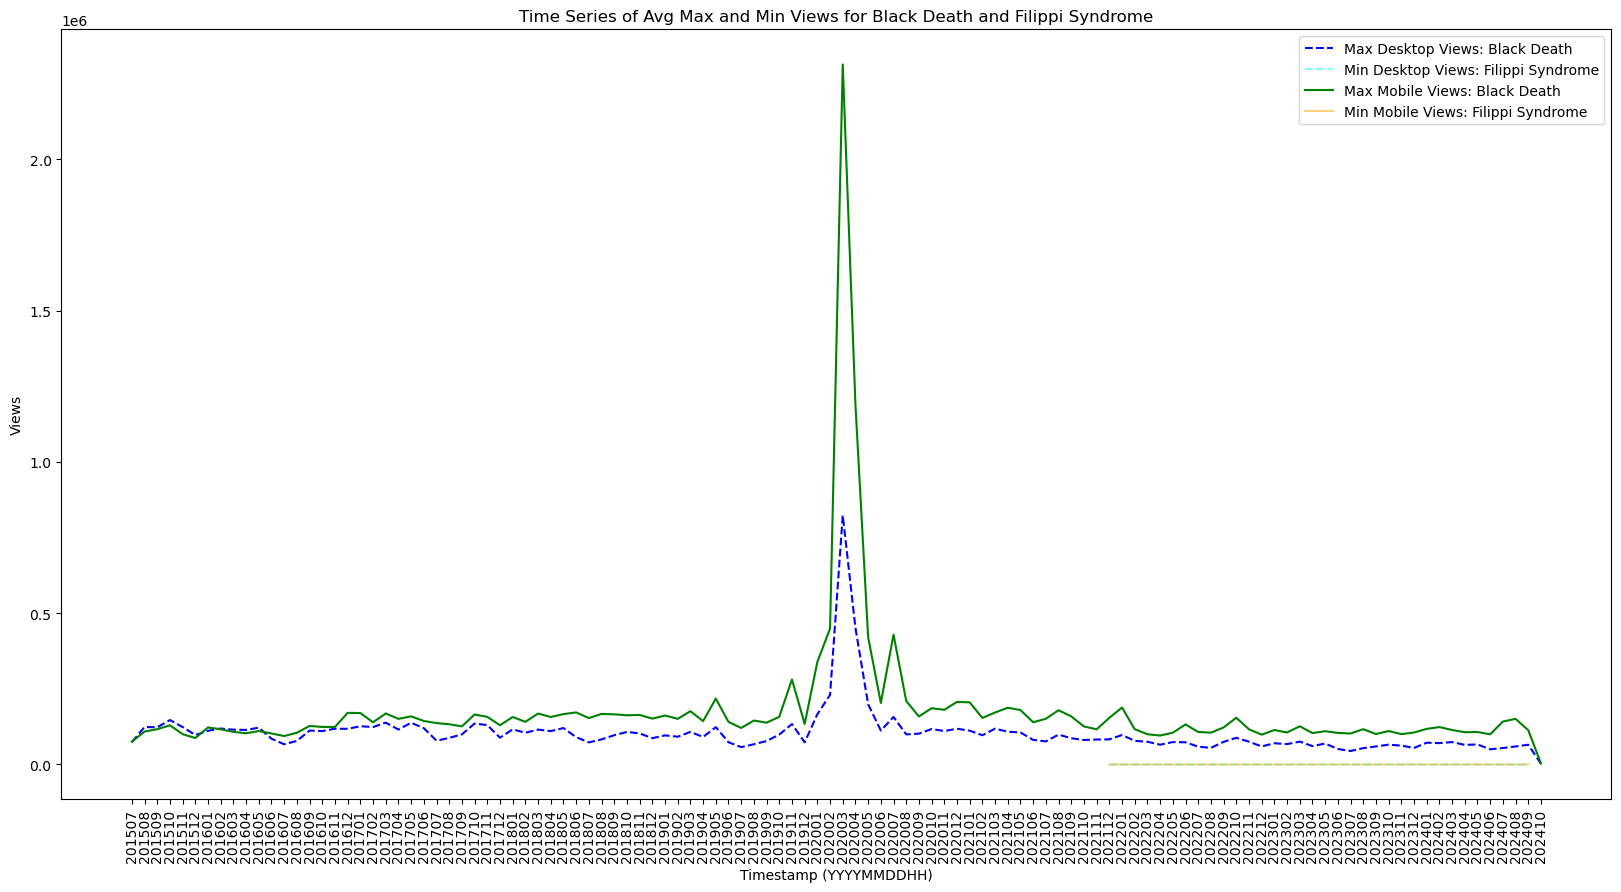

In [89]:
#plot
plt.figure(figsize=(20, 10))

# Max Desktop Views for Black Death
plt.plot(desktop_max_timestamp, desktop_max_views,  linestyle='--', color='blue', label="Max Desktop Views: Black Death")

# Min Desktop Views for Filippi Syndrome
plt.plot(desktop_min_timestamp, desktop_min_views,  linestyle='--', color='cyan', label="Min Desktop Views: Filippi Syndrome", alpha = 0.5)

# Max Mobile Views for Black Death
plt.plot(mobile_max_timestamp, mobile_max_views,  linestyle='-', color='green', label="Max Mobile Views: Black Death")

# Min Mobile Views for Filippi Syndrome
plt.plot(mobile_min_timestamp, mobile_min_views,  linestyle='-', color='orange', label="Min Mobile Views: Filippi Syndrome", alpha = 0.5)

# Adding labels, title, and legend
plt.xlabel('Timestamp (YYYYMMDDHH)')
plt.ylabel('Views')
plt.title('Time Series of Avg Max and Min Views for Black Death and Filippi Syndrome')
plt.xticks(rotation = 90)
plt.legend()

plt.savefig("avg_views_time_series.png", format='png', dpi=300)

# Display the plot
plt.show()



## Top 10 peak page views
Below code gets the 10 artciles with the peak month views

### Top 10 for desktop
Below code gets the required data for the desktop views

In [94]:
desktop_top_views = {} #blank dictionary

In [100]:
for article in articles: #loop through all articles
    if article in desktop_views:
        top_viewed_entry = max(desktop_views[article], key = lambda x:x['views']) #get dictionary entry with maximum views
        desktop_top_views[article] = top_viewed_entry['views'] #get article and its corresponsing max views
        
        

In [102]:
desktop_top_views_sorted = sorted(desktop_top_views.items(), key=lambda x: x[1], reverse=True) #sort by descending

In [107]:
desktop_top_10_articles = [x[0] for x in desktop_top_views_sorted[:10]] #get top 10

In [140]:
#view top 10
desktop_top_10_articles

['Pandemic',
 'Black Death',
 'Chloroquine',
 'Pfeiffer syndrome',
 'Fibrodysplasia ossificans progressiva',
 'Botulism',
 'Robert Koch',
 'Smallpox',
 'Cleidocranial dysostosis',
 'Amyotrophic lateral sclerosis']

### Top 10 for mobile
Below code gets the required data for the mobile views

In [109]:
mobile_top_views = {} #blank dictionary

In [110]:
for article in articles: #loop through all the articles
    if article in mobile_views:
        top_viewed_entry = max(mobile_views[article], key = lambda x:x['views']) #get dictionary entry with maximum views
        mobile_top_views[article] = top_viewed_entry['views'] #get article and its corresponsing max views
        
        

In [111]:
mobile_top_views_sorted = sorted(mobile_top_views.items(), key=lambda x: x[1], reverse=True) #sort by descending

In [112]:
mobile_top_10_articles = [x[0] for x in mobile_top_views_sorted[:10]] #get top 10

In [113]:
mobile_top_10_articles #view top 10

['Black Death',
 'Pandemic',
 'Pfeiffer syndrome',
 'Chloroquine',
 'Stiff-person syndrome',
 'Porphyria',
 'Glioblastoma',
 'Cleidocranial dysostosis',
 'Botulism',
 'Kawasaki disease']

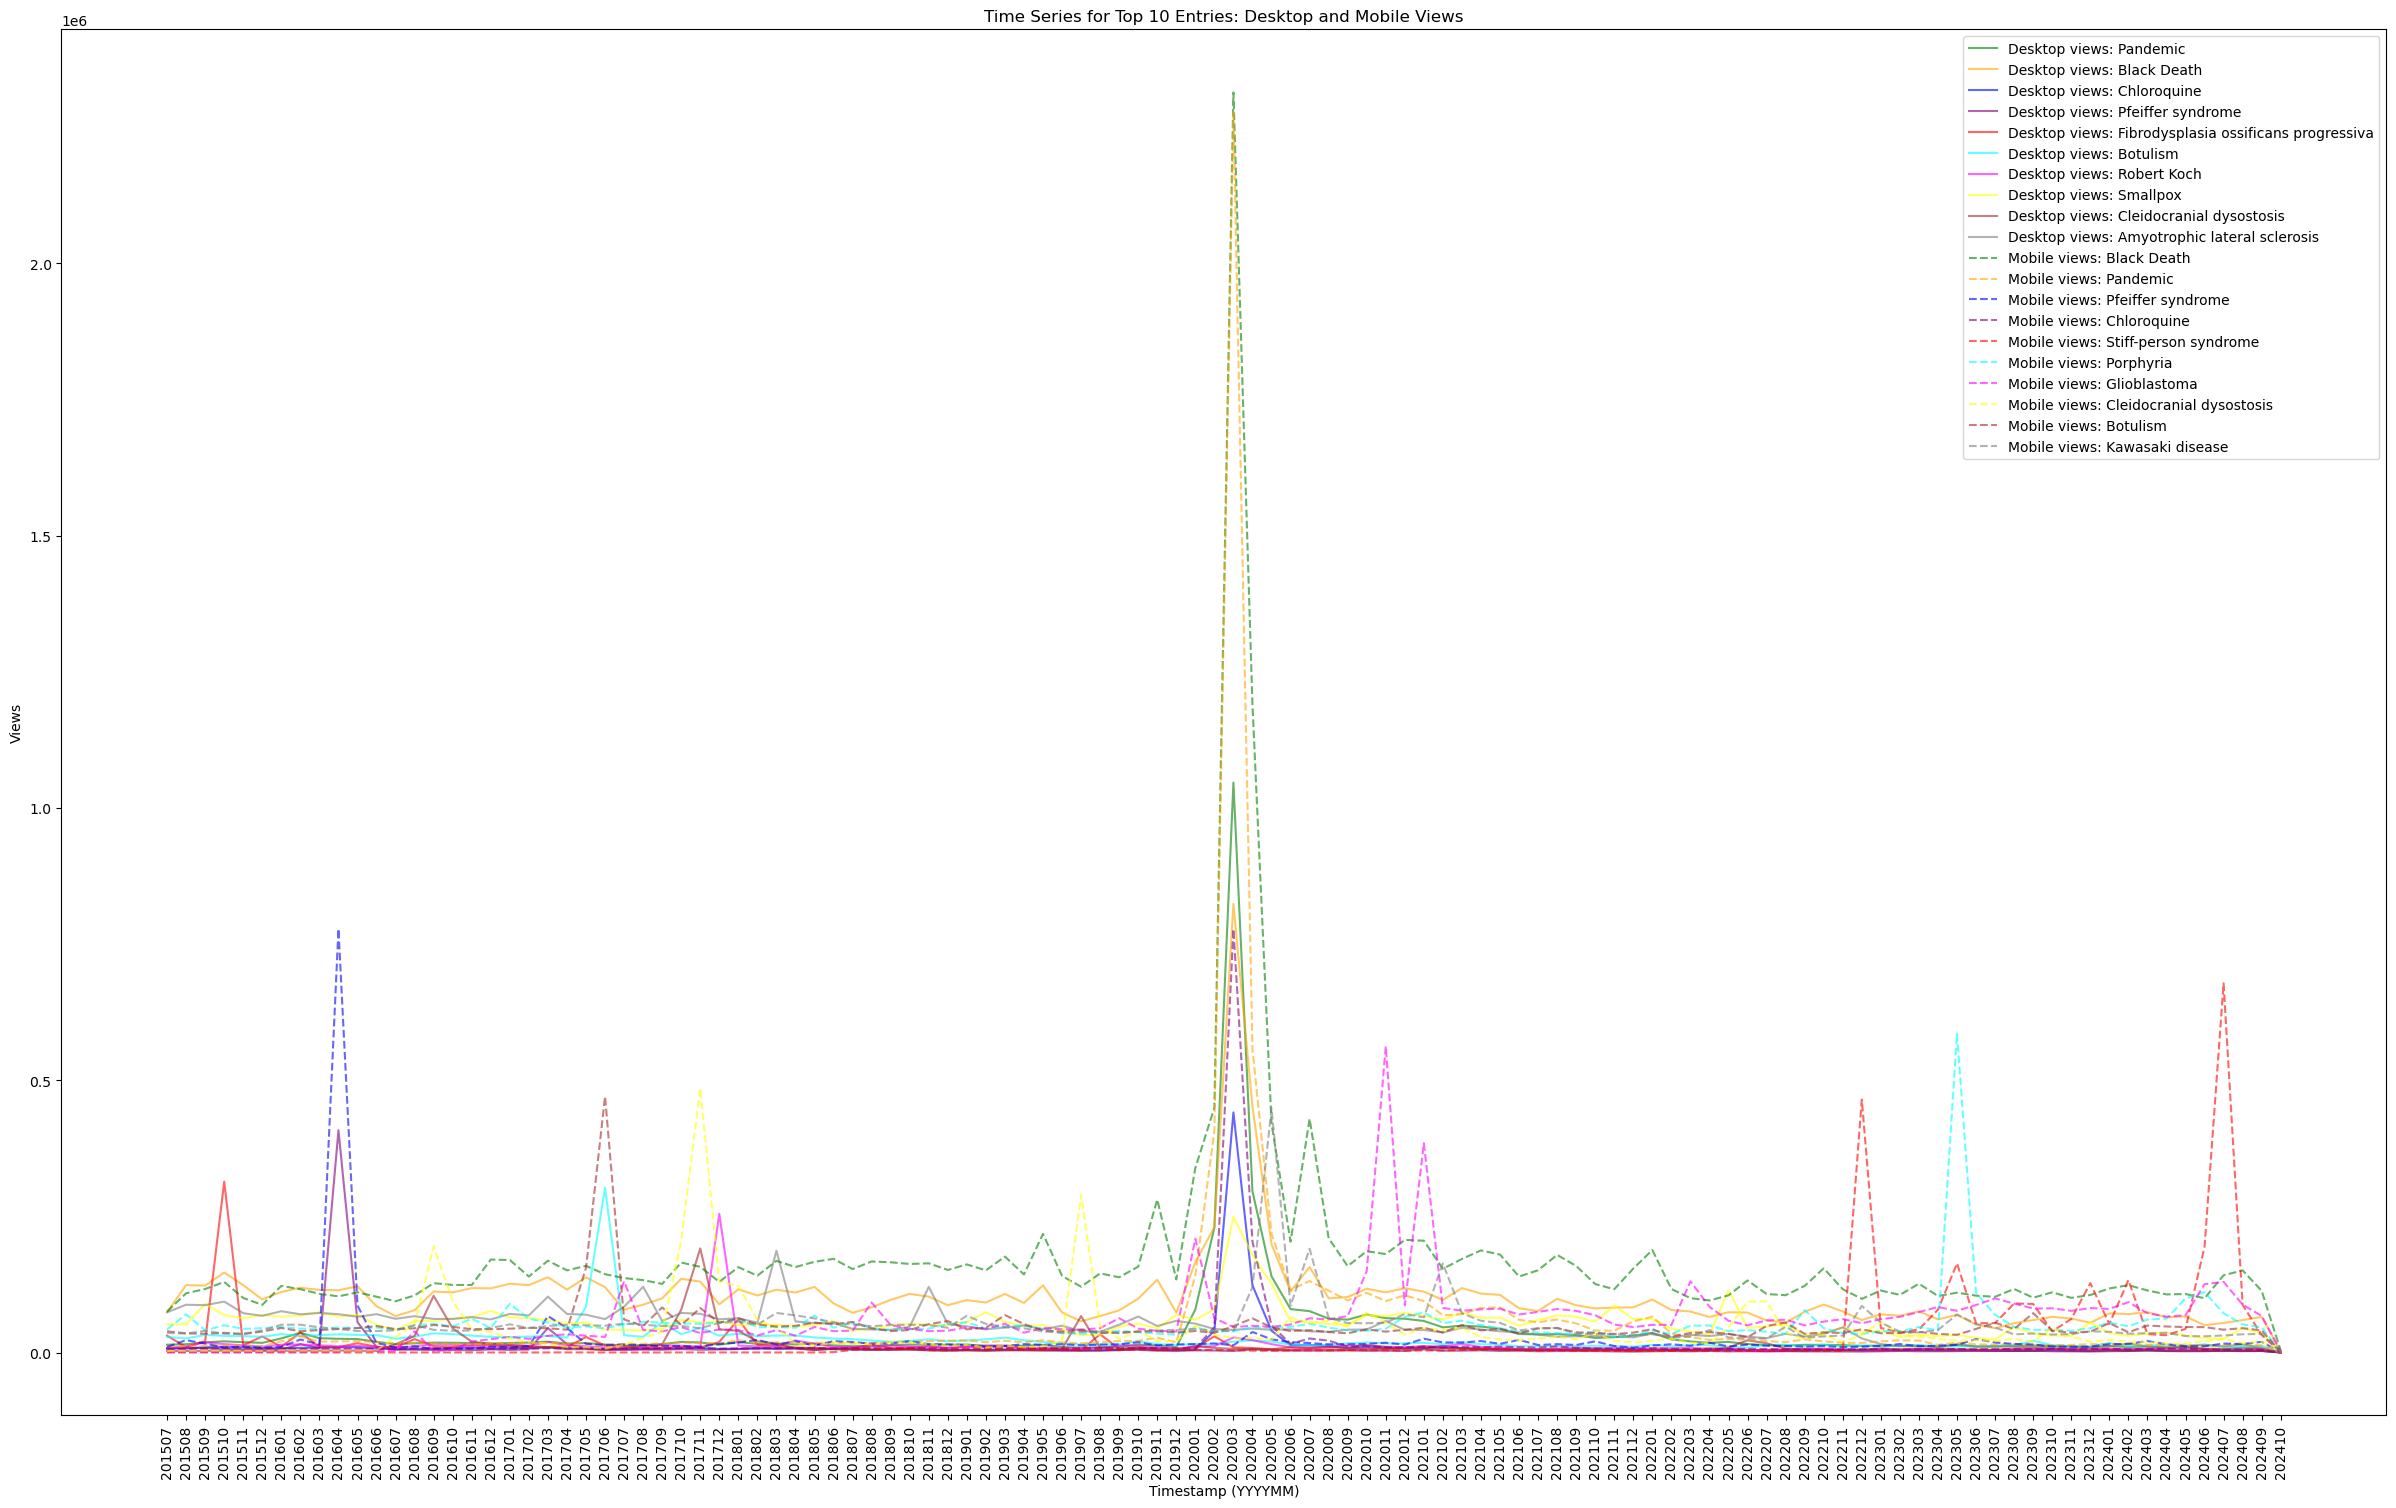

In [156]:
#plot
import matplotlib.pyplot as plt

plt.figure(figsize=(30, 18))

# Define 20 distinct colors for alternating lines
colors = [
    'green', 'orange', 'blue', 'purple', 'red', 'cyan', 'magenta', 'yellow', 'brown', 'gray',
    'teal', 'pink', 'lime', 'lavender', 'maroon', 'navy', 'olive', 'coral', 'gold', 'indigo'
]

# Plot only desktop views 
for idx, entry in enumerate(desktop_top_10_articles):
    if entry in desktop_views:
        timestamps_desktop = [item['timestamp'][:6] for item in desktop_views[entry]]
        views_desktop = [item['views'] for item in desktop_views[entry]]
        plt.plot(timestamps_desktop, views_desktop, linestyle='-', color=colors[idx % 20], label=f'Desktop views: {entry}', alpha=0.6)

# Plot only mobile views
for idx, entry in enumerate(mobile_top_10_articles):
    if entry in mobile_views:
        timestamps_mobile = [item['timestamp'][:6] for item in mobile_views[entry]]
        views_mobile = [item['views'] for item in mobile_views[entry]]
        plt.plot(timestamps_mobile, views_mobile, linestyle='--', color=colors[idx % 20], label=f'Mobile views: {entry}', alpha=0.6)

# Adding labels, title, and legend
plt.xlabel('Timestamp (YYYYMM)')
plt.ylabel('Views')
plt.title('Time Series for Top 10 Entries: Desktop and Mobile Views')
plt.xticks(rotation=90)
plt.legend()

# Save the plot
plt.savefig("top_10_peak_time_series.png", format='png', dpi=300)

# Display the plot
plt.show()


## Fewest months of data
Below code gets data for articles with fewest available months

### For desktop views
Below code gets the required data for the desktop views

In [142]:
desktop_months_data = {} #blank dictionary

In [143]:
for article in articles: #loop through all the articles
    if article in desktop_views:
        desktop_months_data[article] = len(desktop_views[article]) #get months available for an article

In [145]:
desktop_months_data_sorted = sorted(desktop_months_data.items(), key=lambda x: x[1], reverse=False) #sort ascending wise

In [148]:
desktop_least_10_months = [x[0] for x in desktop_months_data_sorted[:10]] #get article name

In [149]:
desktop_least_10_months #view 10 articles with least months data

['Filippi Syndrome',
 'Retinal vasculopathy with cerebral leukoencephalopathy and systemic manifestations',
 'COVID-19 vaccine misinformation and hesitancy',
 'Bradley Monk',
 'CDKL5 deficiency disorder',
 'Joseph Vinetz',
 'Spongy degeneration of the central nervous system',
 'Deaf plus',
 'Hemolytic jaundice',
 'Ellis–Van Creveld syndrome']

### For mobile views
Below code gets the required data for the mobile views

In [150]:
mobile_months_data = {} #blank dicitonary

In [151]:
for article in articles: #loop through all articles
    if article in mobile_views:
        mobile_months_data[article] = len(mobile_views[article]) #get months available for an article

In [152]:
mobile_months_data_sorted = sorted(mobile_months_data.items(), key=lambda x: x[1], reverse=False) #sort ascending wise

In [153]:
mobile_least_10_months = [x[0] for x in mobile_months_data_sorted[:10]] #get article name

In [154]:
mobile_least_10_months #view 10 articles with least months data

['Filippi Syndrome',
 'Retinal vasculopathy with cerebral leukoencephalopathy and systemic manifestations',
 'COVID-19 vaccine misinformation and hesitancy',
 'Bradley Monk',
 'CDKL5 deficiency disorder',
 'Joseph Vinetz',
 'Spongy degeneration of the central nervous system',
 'Deaf plus',
 'Hemolytic jaundice',
 'Ellis–Van Creveld syndrome']

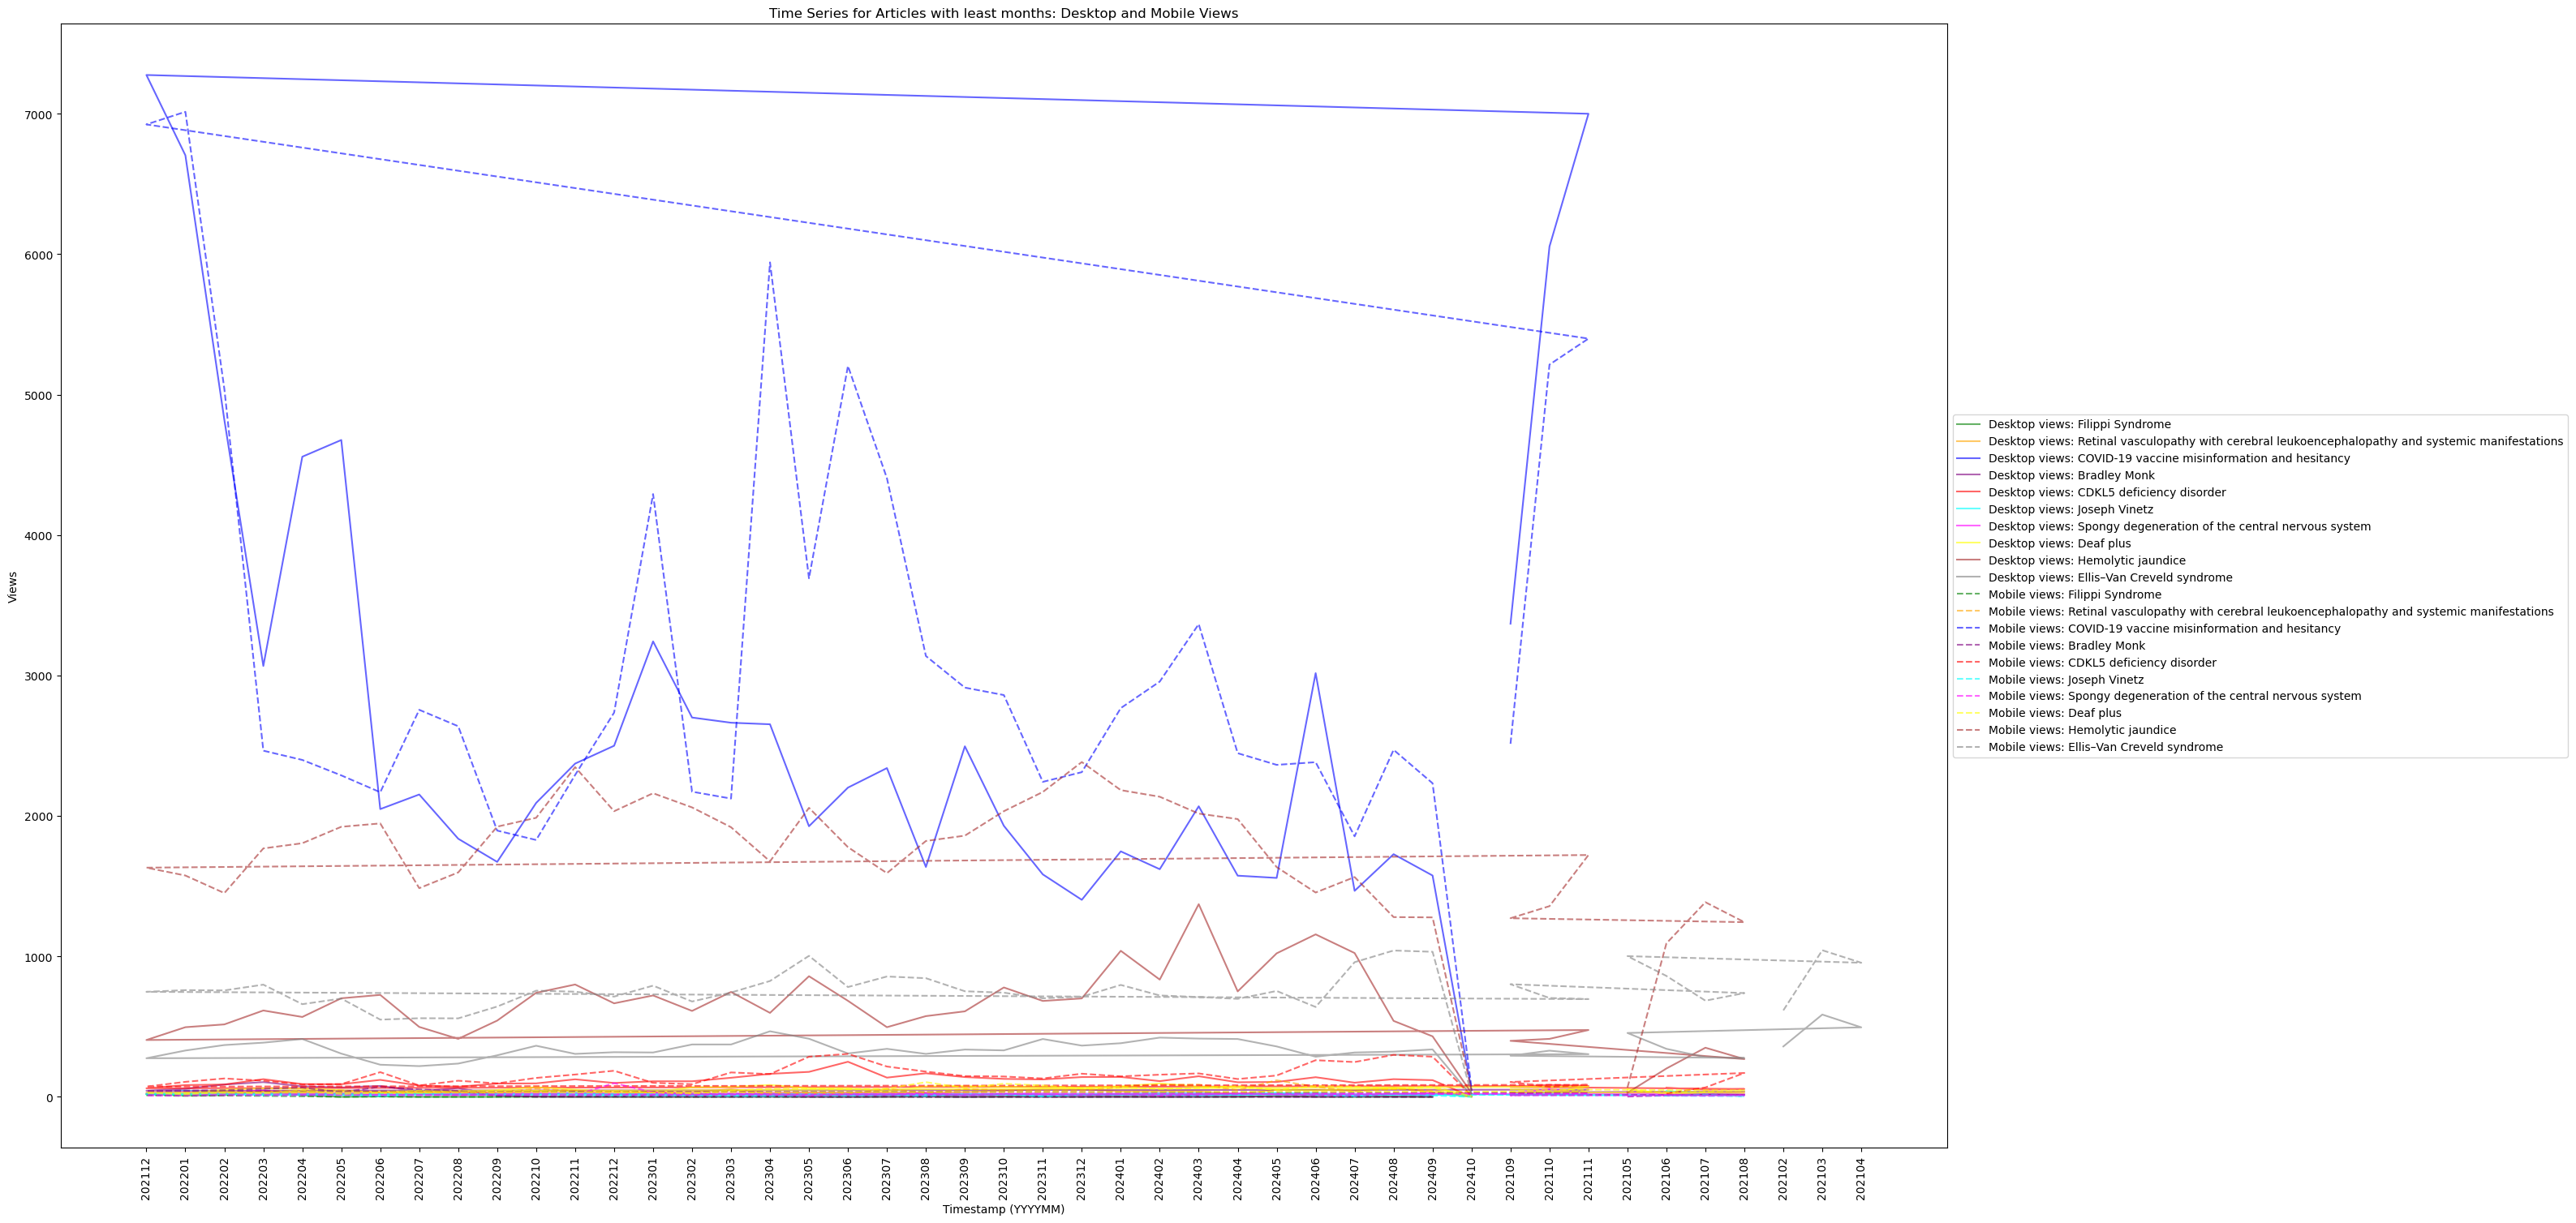

In [159]:
#plot
import matplotlib.pyplot as plt

plt.figure(figsize=(30, 18))

# Define 20 distinct colors for alternating lines
colors = [
    'green', 'orange', 'blue', 'purple', 'red', 'cyan', 'magenta', 'yellow', 'brown', 'gray',
    'teal', 'pink', 'lime', 'lavender', 'maroon', 'navy', 'olive', 'coral', 'gold', 'indigo'
]

# Plot only desktop views 
for idx, entry in enumerate(desktop_least_10_months):
    if entry in desktop_views:
        timestamps_desktop = [item['timestamp'][:6] for item in desktop_views[entry]]
        views_desktop = [item['views'] for item in desktop_views[entry]]
        plt.plot(timestamps_desktop, views_desktop, linestyle='-', color=colors[idx % 20], label=f'Desktop views: {entry}', alpha=0.6)

# Plot only mobile views
for idx, entry in enumerate(mobile_least_10_months):
    if entry in mobile_views:
        timestamps_mobile = [item['timestamp'][:6] for item in mobile_views[entry]]
        views_mobile = [item['views'] for item in mobile_views[entry]]
        plt.plot(timestamps_mobile, views_mobile, linestyle='--', color=colors[idx % 20], label=f'Mobile views: {entry}', alpha=0.6)

# Adding labels, title, and legend
plt.xlabel('Timestamp (YYYYMM)')
plt.ylabel('Views')
plt.title('Time Series for Articles with least months: Desktop and Mobile Views')
plt.xticks(rotation=90)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# Save the plot
plt.savefig("least_10_months_time_series.png", format='png', dpi=300)

# Display the plot
plt.show()
